      index         r     l            t
0         0  0.009752   413     5.258138
1         1  0.020851   817    13.205395
2         2  0.000000  1001    21.573626
3         3  0.000000  1001    30.507195
4         4  0.000000   849    37.978438
...     ...       ...   ...          ...
1720   1720  2.128087  1001  9647.780893
1721   1721  1.781113  1001  9658.979932
1722   1722  2.549148  1001  9666.815931
1723   1723  3.502596  1001  9675.817256
1724   1724  2.039021   988  9683.129401

[1725 rows x 4 columns]


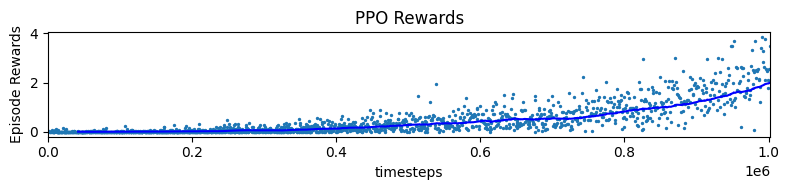

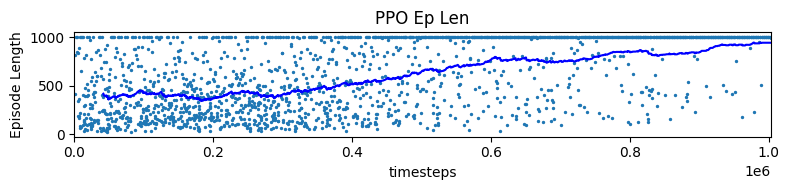

C:\Users\cpigu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\cpigu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



Loaded model ./logs/intermediate_models/121023223235\rl_model.zip 



error: Not connected to physics server.

In [1]:
import os, sys
import gym
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from sys import platform
# may be helpful depending on your system
# if platform =="darwin": # mac
#   import PyQt5
#   matplotlib.use("Qt5Agg")
# else: # linux
#   matplotlib.use('TkAgg')

# stable-baselines3
from stable_baselines3.common.monitor import load_results 
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3 import PPO, SAC
# from stable_baselines3.common.cmd_util import make_vec_env
from stable_baselines3.common.env_util import make_vec_env # fix for newer versions of stable-baselines3

from env.quadruped_gym_env import QuadrupedGymEnv
# utils
from utils.utils import plot_results
from utils.file_utils import get_latest_model, load_all_results


LEARNING_ALG = "PPO"
interm_dir = "./logs/intermediate_models/"
# path to saved models, i.e. interm_dir + '121321105810'
log_dir = interm_dir + '121023223235'

# initialize env configs (render at test time)
# check ideal conditions, as well as robustness to UNSEEN noise during training
env_config = {}
env_config['render'] = True
env_config['record_video'] = False
env_config['add_noise'] = False 
# env_config['competition_env'] = True

# get latest model and normalization stats, and plot 
stats_path = os.path.join(log_dir, "vec_normalize.pkl")
model_name = get_latest_model(log_dir)
monitor_results = load_results(log_dir)
print(monitor_results)
plot_results([log_dir] , 10e10, 'timesteps', LEARNING_ALG + ' ')
plt.show() 

# reconstruct env 
env = lambda: QuadrupedGymEnv(**env_config)
env = make_vec_env(env, n_envs=1)
env = VecNormalize.load(stats_path, env)
env.training = False    # do not update stats at test time
env.norm_reward = False # reward normalization is not needed at test time

# load model
if LEARNING_ALG == "PPO":
    model = PPO.load(model_name, env)
elif LEARNING_ALG == "SAC":
    model = SAC.load(model_name, env)
print("\nLoaded model", model_name, "\n")

obs = env.reset()
episode_reward = 0

# [TODO] initialize arrays to save data from simulation 
#

for i in range(2000):
    action, _states = model.predict(obs,deterministic=False) # sample at test time? ([TODO]: test)
    obs, rewards, dones, info = env.step(action)
    episode_reward += rewards
    if dones:
        print('episode_reward', episode_reward)
        print('Final base position', info[0]['base_pos'])
        episode_reward = 0

    # [TODO] save data from current robot states for plots 
    # To get base position, for example: env.envs[0].env.robot.GetBasePosition() 
    #
    
# [TODO] make plots: